In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from skimage.feature import hog
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import svm, datasets

/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#Most of the code has been reused from the code given in the class
#Reading Data

cars = glob.glob('data/vehicles/**/*.png')
notcars = glob.glob('data/nonvehicles/**/*.png')


## The project was divided into two parts

1. Training a Classifier to distinguish between car and nor car images
2. Using this classifier to distinguish identify cars in a video Stream

## HOG Features

This funciton is responsible for extracting the HOG Features. 

It takes an image as an input and also other factors such as the colour spaces to be used, cells per block, pixels per cell as well as number of orientations to classify the image into. 

In [3]:
# Funtion to return Hog Features based on iputs
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  block_norm= 'L2-Hys', cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                       transform_sqrt=True, visualise=vis, feature_vector=feature_vec)
        return features

## Hog Visualization

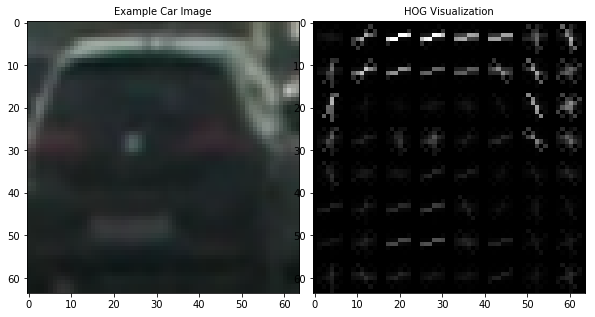

In [4]:
ind = np.random.randint(0, len(cars))
# Read in the image
image = mpimg.imread(cars[ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient= 9, 
                        pix_per_cell= 8, cell_per_block= 2, 
                        vis=True, feature_vec=False)


# Plot the examples
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
fig.subplots_adjust(hspace = .01, wspace=.05)
#axs = axs.ravel()

ax1.set_title('Example Car Image', fontsize=10)
ax1.imshow(image, cmap='gray')

ax2.set_title('HOG Visualization', fontsize=10)
ax2.imshow(hog_image, cmap='gray')

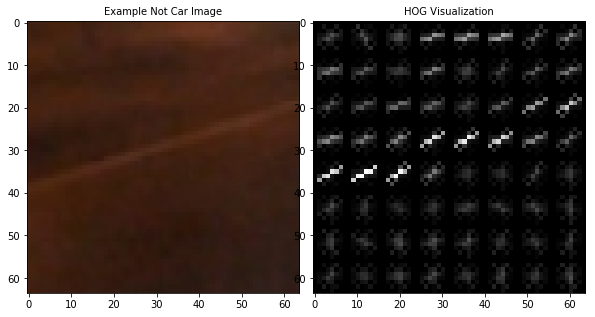

In [5]:
ind = np.random.randint(0, len(notcars))
# Read in the image
image = mpimg.imread(notcars[ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient= 9, 
                        pix_per_cell= 8, cell_per_block= 2, 
                        vis=True, feature_vec=False)


# Plot the examples

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
fig.subplots_adjust(hspace = .01, wspace=.05)
#axs = axs.ravel()

ax1.set_title('Example Not Car Image', fontsize=10)
ax1.imshow(image, cmap='gray')

ax2.set_title('HOG Visualization', fontsize=10)
ax2.imshow(hog_image, cmap='gray')

# fig = plt.figure()
# plt.subplot(121)
# plt.imshow(image, cmap='gray')
# plt.title('Example Not Car Image')
# plt.subplot(122)
# plt.imshow(hog_image, cmap='gray')
# plt.title('HOG Visualization')

## Image preporcessing

This function was created to in somehwat pre process the image

Different features from each image is extracted and used to make a feature vector. This feature vector is a characteristic signature of the image. This faeture vector is then passed to a classifier which looks at signatures from car and non car images and then makes a decision on which signatures represemt which class.

This funtion does the first part of extracting the feature vectors from the images

In [6]:
#Funtion that extracts features
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Empty list
    features = []
    # Go through images
    for file in imgs:
        file_features = []
        image = mpimg.imread(file)
        # apply a color conversion if other than 'RGB'
        
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      
        
        
        #Spatial Fetures
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        
        #Histogram of Colours
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        
        #HOG Features
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
#             file_features.append(hog_features)
        features.append(hog_features)
    # Return list of feature vectors
    return features

## Sliding windows

A sliding window approach is used to search for cars in different parts of the image

Characteristics from these windows will be sent to the classifier to identify cars.

In [7]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
#Find Windows to Search in

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                 xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    
    # Initialize a list to append window positions to
    window_list = []
    
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [8]:
# Function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

## Find cars function

The find cars function from the class was replicated. 

The only variation made from the funciton in teh class material is that I returned the rectangle coordinates. I had a lot of trouble with handling arrays and plotting in this project. But also got to learn a lot through this projeect. 

This function identifies a bounding rectangle identifying the cars in the frame

In [9]:
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,cspace):
    
    rectangles = []
    
    draw_img = np.copy(img)
    
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(image) 
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

#             # Extract the image patch
#             subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
#             # Get color features
#             spatial_features = bin_spatial(subimg, size=spatial_size)
#             hist_features = color_hist(subimg, nbins=hist_bins)

#             # Scale features and make a prediction
#             test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            
            hog_features = X_scaler.transform(np.array(hog_features).reshape(1, -1))
#             hog_features = np.array(hog_features).reshape(1, -1)
            test_prediction = svc.predict(hog_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return rectangles

## Training the classifier

The classifier is trained in this step. The steps followed in this block are as follows:

1. Feature vectors were extracted from the images based on the earlier funcitons.
2. Labels were created for these image as cars or no cars
3. The data was split into a training set and test set
4. A scaler transform based on the training data was then applied on both the training set and the test set
5. I chose a linear SVM as my classifier, I concentrated more on trying to obtain the right feature extraction thatn the classifier choice. 
6. Different combinations for different feature extraction parameters were used. 
7. The following excel snapshot shows the different models that were trained and also the accuracy obtained from each of them. 




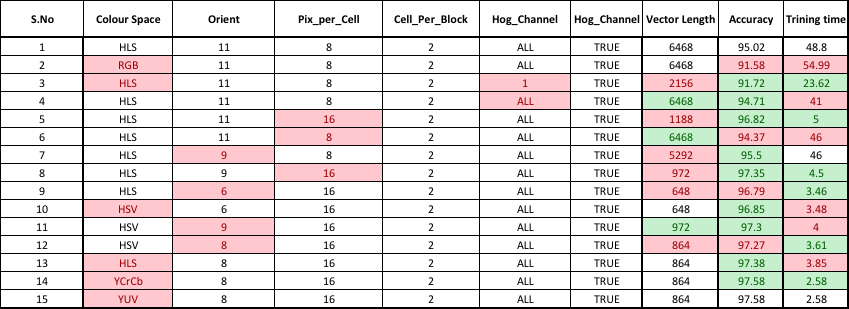



Based on this the final combination of paramters I decided to go with are as follows:

`color_space = 'YcrCb'`

`orient = 12  # HOG`

`pix_per_cell = 16`

`cell_per_block = 2`

`hog_channel = "ALL"`




`Review 2`
Added GridSearchCv to optimise the SVM Used. This improved my accuracy drastically and helped identify cars much better


In [10]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 12  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = False # Spatial features on or off
hist_feat = False # Histogram features on or off
hog_feat = True # HOG features on or off
# y_start_stop = [300, 700] # Min and max in y to search in slide_window()

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

# print('Using:',orient,'orientations',pix_per_cell,
#     'pixels per cell and', cell_per_block,'cells per block')
# print('Feature vector length:', len(X_train[0]))
# # Use a linear SVC 
# svc = LinearSVC()
# # Check the training time for the SVC
# t=time.time()
# svc.fit(X_train, y_train)
# t2 = time.time()
# print(round(t2-t, 2), 'Seconds to train SVC...')
# # Check the score of the SVC
# print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# # Check the prediction time for a single sample
# t=time.time()

parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svc1 = svm.SVC()
svc = GridSearchCV(svc1, parameters)
t=time.time()
svc.fit(X_train, y_train)
sorted(svc.cv_results_.keys())
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

350.98 Seconds to train SVC...


In [11]:
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

Test Accuracy of SVC =  0.9893


The trained classifier was also tested on the test set yielding us an accuracy of about 99%

## Processing the Image through the pipeline

Next steps were to now apply the other functions adn actually use teh classifier to identify cars in an image.

The steps followed were:
1. Deciding the size of the sliding window in different portions of the screen
2. Extracting the Hog Features and letting the calssifier identify cars
3. Create bounding boxes around the cars and track them as they move across the frame.

### Looking at different windows used for searching

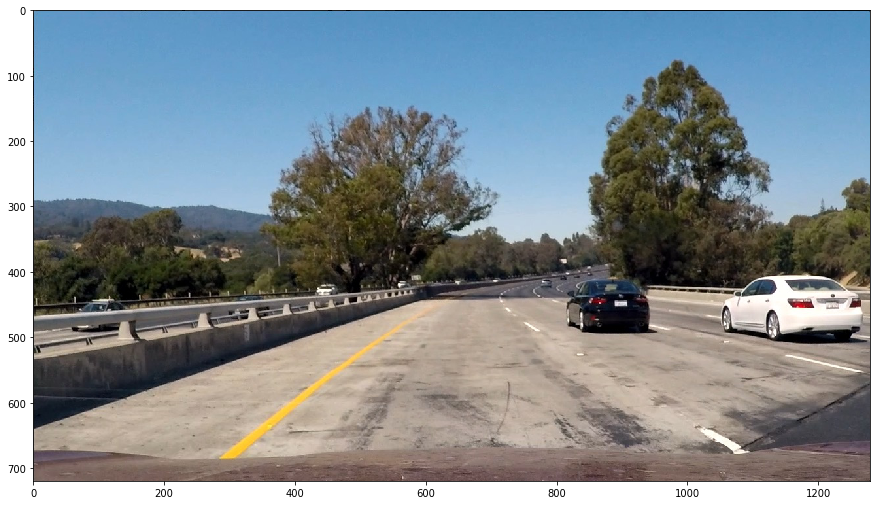

In [12]:
img = mpimg.imread('test_images/test1.jpg')
plt.figure(figsize=(15,15))
plt.imshow(img)

In the following cells you will see different areas in Y where different sized boxes were used to search for images. 

Smaller boxes were used to search for cars farther away, and larger boxes were used to search ofr cars nearby.

It was also noted to not look at the part of the screen that has the trees and the sky in it. Thus our search was limited from in the Y coordinate between 400 and 700 in terms of coordinates.

Also at the same time boxes were overlapped to make sure different aspects of the cars feature were captured by different boxes. 

Further in the project we will see the concept of adding a heat map, denoting the number of boxes that have selected a particualr area as a car. Thus having overlapping boxes makes it easier to increase the heat on detected cars and be able to identify them.

5


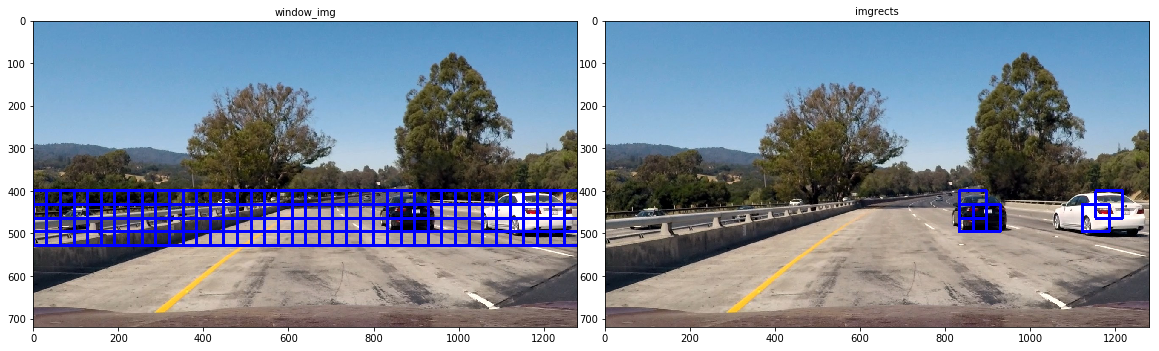

In [13]:
#Window 1 - Smallest Window
ystart = 400
ystop = 528
scale = 1

draw_image = np.copy(img)
image = np.copy(img)
# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)

image = image.astype(np.float32)/255
y_start_stop=[ystart,ystop]
windowsize = np.int(64*scale)

windows=[]
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(windowsize, windowsize), xy_overlap=(0.5, 0.5))

window_img = draw_boxes(draw_image, windows, color=(0, 0, 255), thick=6)                    


detect_image = np.copy(img)
rectangles = find_cars(detect_image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, None, None, color_space)
print(len(rectangles))
imgrects = draw_boxes(detect_image,rectangles)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 20))
fig.subplots_adjust(hspace = .01, wspace=.05)
#axs = axs.ravel()

ax1.set_title('window_img', fontsize=10)
ax1.imshow(window_img)

ax2.set_title('imgrects', fontsize=10)
ax2.imshow(imgrects)


5


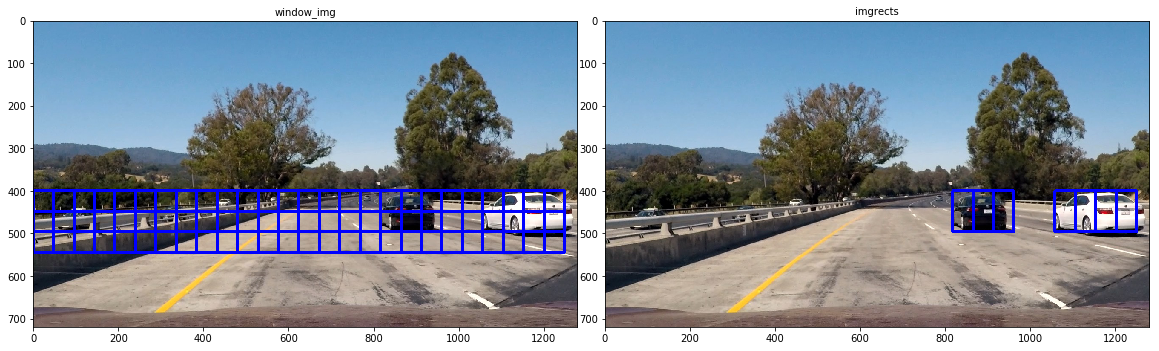

In [14]:
ystart = 400
ystop = 560
scale = 1.5

draw_image = np.copy(img)
# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)

image = image.astype(np.float32)/255
y_start_stop=[ystart,ystop]
windowsize = np.int(64*scale)

windows=[]
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(windowsize, windowsize), xy_overlap=(0.5, 0.5))

window_img = draw_boxes(draw_image, windows, color=(0, 0, 255), thick=6)                    

detect_image = np.copy(img)
rectangles = find_cars(detect_image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, None, None, color_space)
print(len(rectangles))

imgrects = draw_boxes(detect_image,rectangles)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 20))
fig.subplots_adjust(hspace = .01, wspace=.05)
#axs = axs.ravel()

ax1.set_title('window_img', fontsize=10)
ax1.imshow(window_img)

ax2.set_title('imgrects', fontsize=10)
ax2.imshow(imgrects)




3


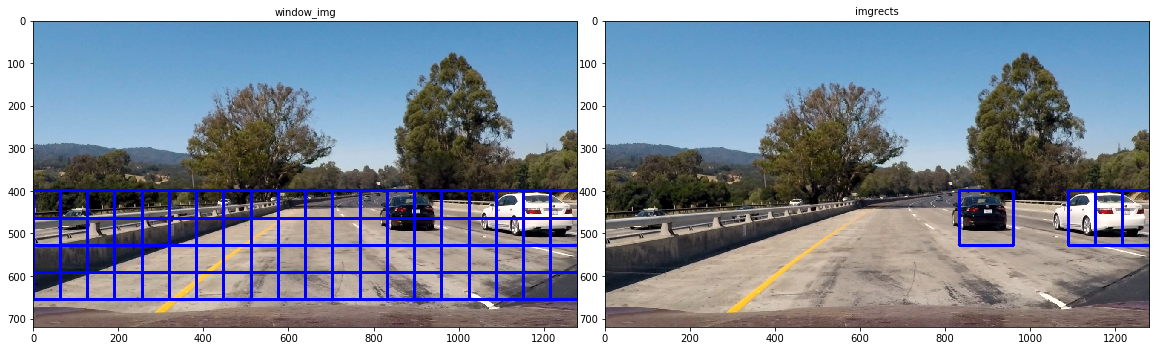

In [15]:
ystart = 400
ystop = 656
scale = 2

draw_image = np.copy(img)
# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)

image = image.astype(np.float32)/255
y_start_stop=[ystart,ystop]
windowsize = np.int(64*scale)

windows=[]
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(windowsize, windowsize), xy_overlap=(0.5, 0.5))

window_img = draw_boxes(draw_image, windows, color=(0, 0, 255), thick=6)                    

detect_image = np.copy(img)
rectangles = find_cars(detect_image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, None, None, color_space)
print(len(rectangles))
imgrects = draw_boxes(detect_image,rectangles)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 20))
fig.subplots_adjust(hspace = .01, wspace=.05)
#axs = axs.ravel()

ax1.set_title('window_img', fontsize=10)
ax1.imshow(window_img)

ax2.set_title('imgrects', fontsize=10)
ax2.imshow(imgrects)






0


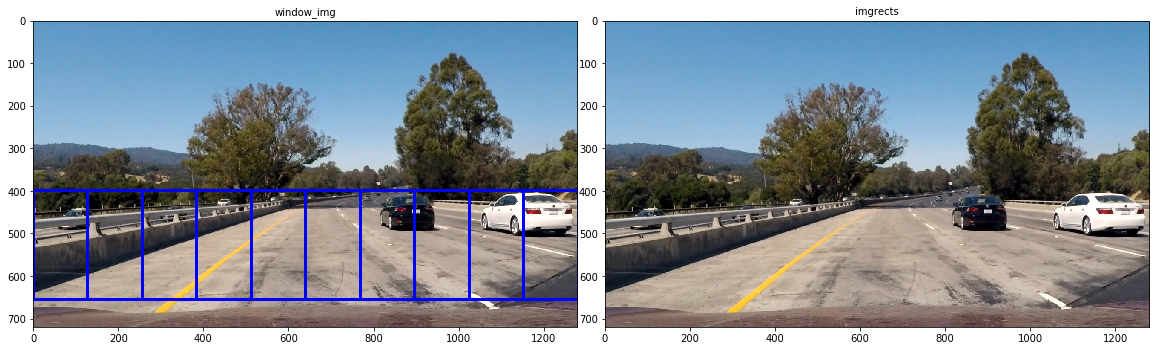

In [16]:
ystart = 400
ystop = 656
scale = 4

draw_image = np.copy(img)
# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)

image = image.astype(np.float32)/255
y_start_stop=[ystart,ystop]
windowsize = np.int(64*scale)

windows=[]
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(windowsize, windowsize), xy_overlap=(0.5, 0.5))

window_img = draw_boxes(draw_image, windows, color=(0, 0, 255), thick=6)  


detect_image = np.copy(img)
rectangles = find_cars(detect_image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, None, None, color_space)
print(len(rectangles))
imgrects = draw_boxes(detect_image,rectangles)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 20))
fig.subplots_adjust(hspace = .01, wspace=.05)
#axs = axs.ravel()

ax1.set_title('window_img', fontsize=10)
ax1.imshow(window_img)

ax2.set_title('imgrects', fontsize=10)
ax2.imshow(imgrects)

### Heat Map

This funtion was used to denota heat map based on the rectanges and their identification. This helped us define a threshold and remove a lot of fals positives from our detection. 

Although a good method I was not able to completely eliminate the false positives. I am not completely satisfied with the false positive elimination but I belive give the methods used this is a pretty good result.

In [17]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

Adding Threshold to the Heat Map

In [18]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

Funtion to draw boxes once the labels have been deduces

In [19]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    rects = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rects.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image and final rectangles
    return img, rects

## Pipeline

This is the pipeline used for images. This is also the pipeline that has been used to show most of the images that have been Printed in the reports. It is just an aggregation of the steps we discussed aobve

In [20]:
def pipeline(img,svc,X_scaler, orient, pix_per_cell, cell_per_block, color_space):
    
    detect_image = np.copy(img)
    draw_image = np.copy(img)
    heat_image = np.copy(img)

    rectangles = []

    ystart = 400
    ystop = 528
    scale = 1
    rectangles.append(find_cars(detect_image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, None, None, color_space))

    ystart = 400
    ystop = 560
    scale = 1.5
    rectangles.append(find_cars(detect_image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, None, None, color_space))

    ystart = 400
    ystop = 656
    scale = 2
    rectangles.append(find_cars(detect_image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, None, None, color_space))

    ystart = 400
    ystop = 656
    scale = 4
    rectangles.append(find_cars(detect_image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, None, None, color_space))

    rectangles = [item for sublist in rectangles for item in sublist] 
    img_rect = draw_boxes(draw_image, rectangles)

    heatmap_img = np.zeros_like(heat_image[:,:,0])
    heatmap_image = add_heat(heatmap_img, rectangles)
    
    threshold_image = np.copy(heatmap_image)
    
    thresh = 2
    heatmap_image_thresh = apply_threshold(threshold_image, thresh)
    
    label_image = np.copy(heatmap_image_thresh)
    
    from scipy.ndimage.measurements import label
    labels = label(label_image)

    draw_image_2 = np.copy(img)
    draw_img, rect = draw_labeled_bboxes(draw_image_2, labels)
    
    return draw_img,rectangles,img_rect,heatmap_image,heatmap_image_thresh,labels


## Video Pipeline

This pipeline only takes an image as an input and return the final image as the output. 

I did struglle with how to input the Classifier and the X_Scaler into this funtion. Considering that I cannot keep training the classifier everytime I call teh function. I was not able to identify a method but when I did remove them fromt eh argument list all functions still seemed to work. I need to look into this further but it does serve teh purpose for now.

In [21]:
def Videopipeline(img):
    
    orient = 12
    pix_per_cell = 16 
    cell_per_block = 2
    color_space = 'YCrCb'
    
    detect_image = np.copy(img)
    draw_image = np.copy(img)
    heat_image = np.copy(img)

    rectangles = []

    ystart = 400
    ystop = 528
    scale = 1
    rectangles.append(find_cars(detect_image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, None, None, color_space))

    ystart = 400
    ystop = 560
    scale = 1.5
    rectangles.append(find_cars(detect_image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, None, None, color_space))

    ystart = 400
    ystop = 656
    scale = 2
    rectangles.append(find_cars(detect_image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, None, None, color_space))

    ystart = 400
    ystop = 656
    scale = 4
    rectangles.append(find_cars(detect_image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, None, None, color_space))

    rectangles = [item for sublist in rectangles for item in sublist] 
    img_rect = draw_boxes(draw_image, rectangles)

    heatmap_img = np.zeros_like(heat_image[:,:,0])
    heatmap_image = add_heat(heatmap_img, rectangles)
    
    threshold_image = np.copy(heatmap_image)
    
    thresh = 2
    heatmap_image_thresh = apply_threshold(threshold_image, thresh)
    
    label_image = np.copy(heatmap_image_thresh)
    
    from scipy.ndimage.measurements import label
    labels = label(label_image)

    draw_image_2 = np.copy(img)
    draw_img, rect = draw_labeled_bboxes(draw_image_2, labels)
    
    return draw_img

13
2


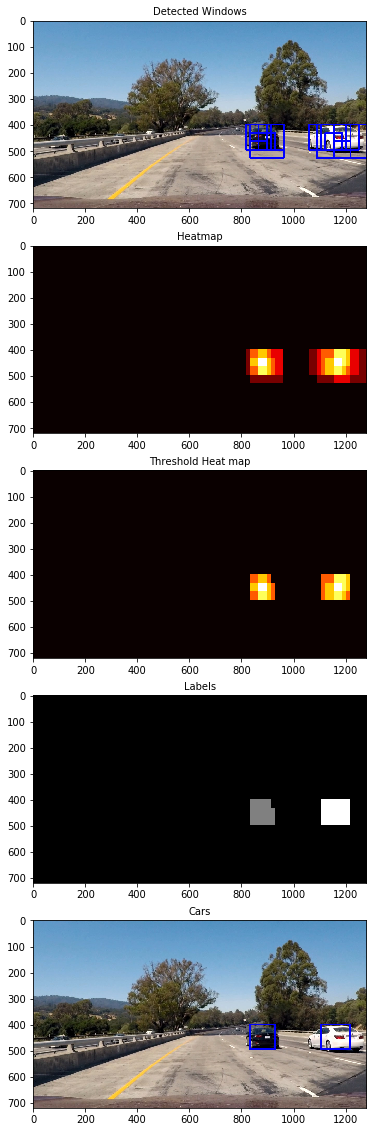

In [22]:
#RUnning on an Image
img = mpimg.imread('test_images/test1.jpg')
draw_img,rectangles,img_rect,heatmap_image,heatmap_image_thresh,labels = pipeline(img,svc,X_scaler, orient, pix_per_cell, cell_per_block, color_space)
 
# heat_image = np.copy(img)
print(len(rectangles))


fig,axs = plt.subplots(5, 1, figsize=(20, 20))
fig.subplots_adjust(hspace = .2, wspace=.5)
axs = axs.ravel()

axs[0].set_title('Detected Windows', fontsize=10)
axs[0].imshow(img_rect)

axs[1].set_title('Heatmap', fontsize=10)
axs[1].imshow(heatmap_image, cmap='hot')

axs[2].set_title('Threshold Heat map', fontsize=10)
axs[2].imshow(heatmap_image_thresh, cmap='hot')

axs[3].set_title('Labels', fontsize=10)
axs[3].imshow(labels[0],cmap='gray')

print(labels[1])

axs[4].set_title('Cars', fontsize=10)
axs[4].imshow(draw_img)

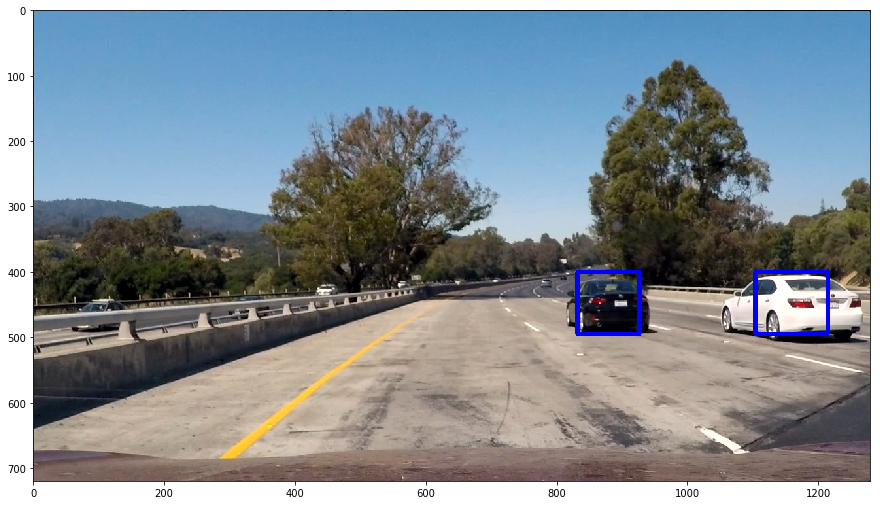

In [23]:
plt.figure(figsize=(15,15))
plt.imshow(draw_img)

In [24]:
## Running on a Video
from moviepy.editor import VideoFileClip
from IPython.display import HTML

video_output1 = 'project_output.mp4'
video_input1 = VideoFileClip('project_video.mp4').subclip(0,50)
processed_video = video_input1.fl_image(Videopipeline)
%time processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4


100%|█████████▉| 1250/1251 [12:46<00:00,  1.57it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output.mp4 

CPU times: user 12min 35s, sys: 23.5 s, total: 12min 58s
Wall time: 12min 46s


## Video Output
Please run the next cell to view the vide detecting the cars

I was able to reasonable detect the position of the cars with the bounding boxes jumping around a lot but always staying in or on the car. 

One major issue I had was with the left yellow lane line. During the turns the calssifier was detecting it as a car and thus kept thorwing up false positives on it

Another area this model struggled was in the shadow when we pass unde the tree. At this point the model identifies the shadows as a car and thus leads to a few false positives.

`Review 2` Majority of the fals positives have been removed. Even thought the boxes detecting cars still jump around a lot

In [31]:
#Video Output
project_output = 'project_output.mp4'
from moviepy.editor import VideoFileClip
from IPython.display import HTML

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))

## Previous Frame information 

I tried an implementation to use information from previous frames. This improved the recognition of the cars a lot and made their bounding boxes very stable and almost always detecting cars throught the video.

But this came with its downsides with a significant increase in the numbe rof false positives. This was an area I could not explore Furhter nad hope to be able to do it sometime int eh future.

`Review 2` I added the implementation to look at the previous frames and use that information to improve teh current frame detection. Although better at tracking the cars this methos did introduce more false positives that the earlier one. 

In [28]:
# Define a class to store data from video
class Vehicle_Detect():
    def __init__(self):
        # history of rectangles previous n frames
        self.prev_rects = [] 
        
    def add_rects(self, rects):
        self.prev_rects.append(rects)
        if len(self.prev_rects) > 15:
            # throw out oldest rectangle set(s)
            self.prev_rects = self.prev_rects[len(self.prev_rects)-15:]

In [29]:
def Videopipeline2(img):
    
    orient = 12
    pix_per_cell = 16 
    cell_per_block = 2
    color_space = 'YCrCb'
    
    detect_image = np.copy(img)
    draw_image = np.copy(img)
    heat_image = np.copy(img)

    rectangles = []

    ystart = 400
    ystop = 528
    scale = 1
    rectangles.append(find_cars(detect_image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, None, None, color_space))

    ystart = 400
    ystop = 560
    scale = 1.5
    rectangles.append(find_cars(detect_image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, None, None, color_space))

    ystart = 400
    ystop = 656
    scale = 2
    rectangles.append(find_cars(detect_image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, None, None, color_space))

    ystart = 400
    ystop = 656
    scale = 4
    rectangles.append(find_cars(detect_image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, None, None, color_space))

    rectangles = [item for sublist in rectangles for item in sublist] 
    
    if len(rectangles) > 0:
        det.add_rects(rectangles)
    
    heatmap_img = np.zeros_like(img[:,:,0])
    for rect_set in det.prev_rects:
        heatmap_img = add_heat(heatmap_img, rect_set)
    
    heatmap_img = apply_threshold(heatmap_img, 1 + len(det.prev_rects)//2)
    
    from scipy.ndimage.measurements import label
     
    labels = label(heatmap_img)
    draw_img, rect = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img



In [33]:
## Running on a Video
from moviepy.editor import VideoFileClip
from IPython.display import HTML

det = Vehicle_Detect()
video_output1 = 'Vehicle_detection_tracking_final_output.mp4'
video_input1 = VideoFileClip('project_video.mp4').subclip(10,50)
processed_video = video_input1.fl_image(Videopipeline2)
%time processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video Vehicle_detection_tracking_final_output.mp4
[MoviePy] Writing video Vehicle_detection_tracking_final_output.mp4


100%|█████████▉| 1000/1001 [10:43<00:00,  1.57it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: Vehicle_detection_tracking_final_output.mp4 

CPU times: user 10min 33s, sys: 16.9 s, total: 10min 50s
Wall time: 10min 44s


In [34]:
#Video Output
project_output = 'Vehicle_detection_tracking_final_output.mp4'
from moviepy.editor import VideoFileClip
from IPython.display import HTML

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))